In [1]:
from cobra.io import read_sbml_model

nj4 = read_sbml_model("GEMs/NJ4_curated.xml")
m5 = read_sbml_model("GEMs/M5_curated.xml")

## static sim

look into the possibilities for crossfeeding

## dynamic sim
sequential community

In [2]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

m5_med = media_db[media_db["medium"] == "m5_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in m5_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}

# TODO: calculate xylan (60 g/L concentration) to an amount of moles that makes sense
added_metabilotes["xylan4_e"] = 2.5
added_metabilotes["xylan8_e"] = 5

#added_metabilotes["xyl__D_e"] = 2 #TODO: remove

INOC_TIME = 12

In [3]:
# arbitrary values rn - trying to get the model to produce extracelullar xylose

m5.reactions.XYLANabc.bounds = (0, 0)
m5.reactions.XYLt2.bounds = (0, 5)
m5.reactions.XYLabc.bounds = (0, 0)
m5.reactions.XYLtex.bounds = (0, 0)

nj4.reactions.XYLANabc.bounds = (0, 0)

In [4]:
from utils import comets_functions as cf
from utils.kinetic_params import KINETIC_PARAMS

first_sim, second_sim = cf.sequental_com(m5, nj4, init_medium=added_metabilotes, total_sim_time=20, inoc_time=INOC_TIME, initial_pop_m5=0.0001)


Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!


In [5]:
bm, met, fluxes = cf.collapse_sequential_sim(first_sim, second_sim)

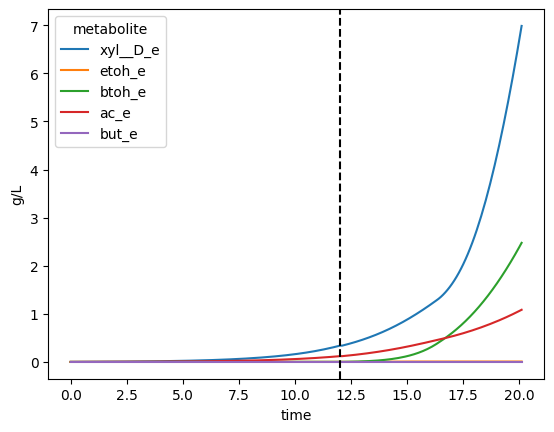

In [6]:
metabolites = ["xyl__D_e", "etoh_e", "but_e", "btoh_e", "ac_e"]#, "xylan4_e"]

cf.plot_metabolites(metabolites_time_series=met, metabolites=metabolites, inoc_time=INOC_TIME)

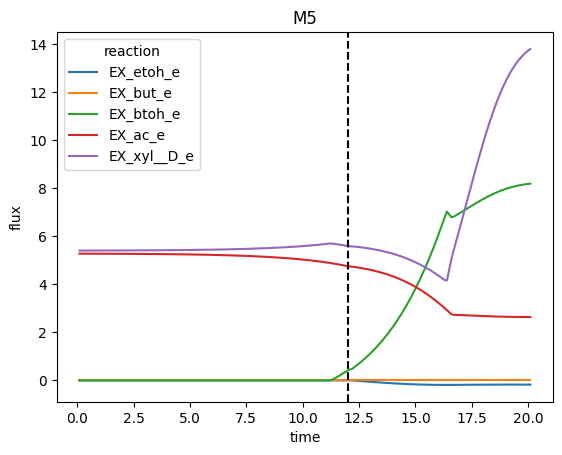

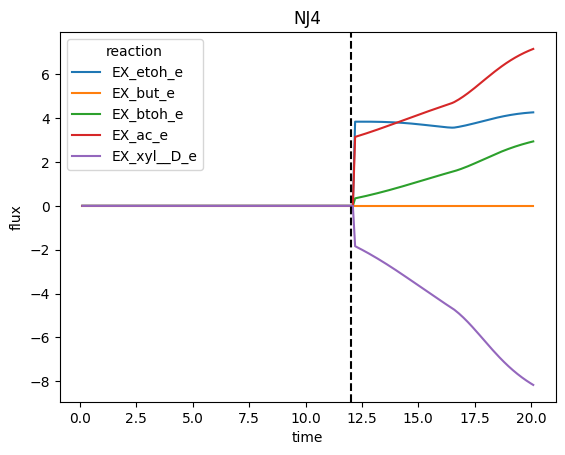

In [7]:
import matplotlib.pyplot as plt

production_reactions = ["EX_etoh_e", "EX_but_e", "EX_btoh_e", "EX_ac_e", "EX_xyl__D_e"]

cf.plot_reaction_flux(fluxes=fluxes["M5"], reactions=production_reactions, inoc_time=INOC_TIME);
plt.title('M5')
plt.show()

cf.plot_reaction_flux(fluxes=fluxes["NJ4"], reactions=production_reactions, inoc_time=INOC_TIME);
plt.title('NJ4')
plt.show()

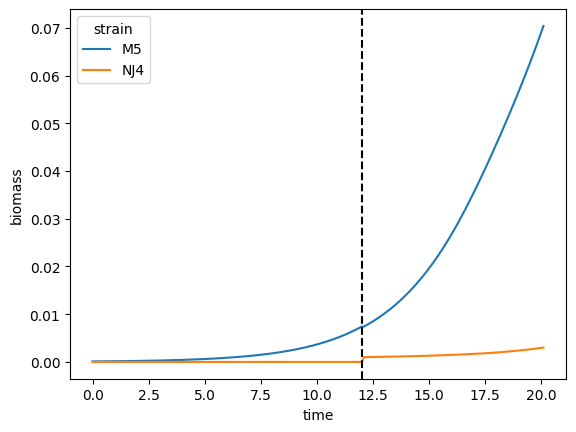

In [8]:
cf.plot_biomass(total_biomass=bm, inoc_time=INOC_TIME)